<a href="https://colab.research.google.com/github/vishnuvirat/NLP-HW/blob/main/Copy_of_HW1_(more_instructed).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/kwang2049/nlp4web-codebase.git
!git clone https://github.com/kwang2049/nlp4web-codebase.git  # You can always check the content of this simple codebase at any time
!pip install gradio  # we also need this additionally for this homework

  Cloning https://github.com/kwang2049/nlp4web-codebase.git to /tmp/pip-req-build-jdqh_998
  Running command git clone --filter=blob:none --quiet https://github.com/kwang2049/nlp4web-codebase.git /tmp/pip-req-build-jdqh_998
  Resolved https://github.com/kwang2049/nlp4web-codebase.git to commit 83f9afbbf7e372c116fdd04997a96449007f861f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Pre-requisite code

The code within this section will be used in the tasks. Please do not change these code lines.

### SciQ loading and counting

In [7]:
from dataclasses import dataclass
import pickle
import os
from typing import Iterable, Callable, List, Dict, Optional, Type, TypeVar
from nlp4web_codebase.ir.data_loaders.dm import Document
from collections import Counter
import tqdm
import re
import nltk
nltk.download("stopwords", quiet=True)
from nltk.corpus import stopwords as nltk_stopwords

LANGUAGE = "english"
word_splitter = re.compile(r"(?u)\b\w\w+\b").findall
stopwords = set(nltk_stopwords.words(LANGUAGE))


def word_splitting(text: str) -> List[str]:
    return word_splitter(text.lower())

def lemmatization(words: List[str]) -> List[str]:
    return words  # We ignore lemmatization here for simplicity

def simple_tokenize(text: str) -> List[str]:
    words = word_splitting(text)
    tokenized = list(filter(lambda w: w not in stopwords, words))
    tokenized = lemmatization(tokenized)
    return tokenized

T = TypeVar("T", bound="InvertedIndex")

@dataclass
class PostingList:
    term: str  # The term
    docid_postings: List[int]  # docid_postings[i] means the docid (int) of the i-th associated posting
    tweight_postings: List[float]  # tweight_postings[i] means the term weight (float) of the i-th associated posting


@dataclass
class InvertedIndex:
    posting_lists: List[PostingList]  # docid -> posting_list
    vocab: Dict[str, int]
    cid2docid: Dict[str, int]  # collection_id -> docid
    collection_ids: List[str]  # docid -> collection_id
    doc_texts: Optional[List[str]] = None  # docid -> document text

    def save(self, output_dir: str) -> None:
        os.makedirs(output_dir, exist_ok=True)
        with open(os.path.join(output_dir, "index.pkl"), "wb") as f:
            pickle.dump(self, f)

    @classmethod
    def from_saved(cls: Type[T], saved_dir: str) -> T:
        index = cls(
            posting_lists=[], vocab={}, cid2docid={}, collection_ids=[], doc_texts=None
        )
        with open(os.path.join(saved_dir, "index.pkl"), "rb") as f:
            index = pickle.load(f)
        return index


# The output of the counting function:
@dataclass
class Counting:
    posting_lists: List[PostingList]
    vocab: Dict[str, int]
    cid2docid: Dict[str, int]
    collection_ids: List[str]
    dfs: List[int]  # tid -> df
    dls: List[int]  # docid -> doc length
    avgdl: float
    nterms: int
    doc_texts: Optional[List[str]] = None

def run_counting(
    documents: Iterable[Document],
    tokenize_fn: Callable[[str], List[str]] = simple_tokenize,
    store_raw: bool = True,  # store the document text in doc_texts
    ndocs: Optional[int] = None,
    show_progress_bar: bool = True,
) -> Counting:
    """Counting TFs, DFs, doc_lengths, etc."""
    posting_lists: List[PostingList] = []
    vocab: Dict[str, int] = {}
    cid2docid: Dict[str, int] = {}
    collection_ids: List[str] = []
    dfs: List[int] = []  # tid -> df
    dls: List[int] = []  # docid -> doc length
    nterms: int = 0
    doc_texts: Optional[List[str]] = []
    for doc in tqdm.tqdm(
        documents,
        desc="Counting",
        total=ndocs,
        disable=not show_progress_bar,
    ):
        if doc.collection_id in cid2docid:
            continue
        collection_ids.append(doc.collection_id)
        docid = cid2docid.setdefault(doc.collection_id, len(cid2docid))
        toks = tokenize_fn(doc.text)
        tok2tf = Counter(toks)
        dls.append(sum(tok2tf.values()))
        for tok, tf in tok2tf.items():
            nterms += tf
            tid = vocab.get(tok, None)
            if tid is None:
                posting_lists.append(
                    PostingList(term=tok, docid_postings=[], tweight_postings=[])
                )
                tid = vocab.setdefault(tok, len(vocab))
            posting_lists[tid].docid_postings.append(docid)
            posting_lists[tid].tweight_postings.append(tf)
            if tid < len(dfs):
                dfs[tid] += 1
            else:
                dfs.append(0)
        if store_raw:
            doc_texts.append(doc.text)
        else:
            doc_texts = None
    return Counting(
        posting_lists=posting_lists,
        vocab=vocab,
        cid2docid=cid2docid,
        collection_ids=collection_ids,
        dfs=dfs,
        dls=dls,
        avgdl=sum(dls) / len(dls),
        nterms=nterms,
        doc_texts=doc_texts,
    )

from nlp4web_codebase.ir.data_loaders.sciq import load_sciq
sciq = load_sciq()
counting = run_counting(documents=iter(sciq.corpus), ndocs=len(sciq.corpus))

________________________________________________________________________________
[Memory] Calling nlp4web_codebase.ir.data_loaders.sciq.load_sciq...
load_sciq()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.02k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.99M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/339k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/343k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11679 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

________________________________________________________load_sciq - 5.2s, 0.1min


Counting: 100%|██████████| 12160/12160 [00:01<00:00, 7241.90it/s]


### BM25 Index

In [8]:
from __future__ import annotations
from dataclasses import asdict, dataclass
import math
import os
from typing import Iterable, List, Optional, Type
import tqdm
from nlp4web_codebase.ir.data_loaders.dm import Document


@dataclass
class BM25Index(InvertedIndex):

    @staticmethod
    def tokenize(text: str) -> List[str]:
        return simple_tokenize(text)

    @staticmethod
    def cache_term_weights(
        posting_lists: List[PostingList],
        total_docs: int,
        avgdl: float,
        dfs: List[int],
        dls: List[int],
        k1: float,
        b: float,
    ) -> None:
        """Compute term weights and caching"""

        N = total_docs
        for tid, posting_list in enumerate(
            tqdm.tqdm(posting_lists, desc="Regularizing TFs")
        ):
            idf = BM25Index.calc_idf(df=dfs[tid], N=N)
            for i in range(len(posting_list.docid_postings)):
                docid = posting_list.docid_postings[i]
                tf = posting_list.tweight_postings[i]
                dl = dls[docid]
                regularized_tf = BM25Index.calc_regularized_tf(
                    tf=tf, dl=dl, avgdl=avgdl, k1=k1, b=b
                )
                posting_list.tweight_postings[i] = regularized_tf * idf

    @staticmethod
    def calc_regularized_tf(
        tf: int, dl: float, avgdl: float, k1: float, b: float
    ) -> float:
        return tf / (tf + k1 * (1 - b + b * dl / avgdl))

    @staticmethod
    def calc_idf(df: int, N: int):
        return math.log(1 + (N - df + 0.5) / (df + 0.5))

    @classmethod
    def build_from_documents(
        cls: Type[BM25Index],
        documents: Iterable[Document],
        store_raw: bool = True,
        output_dir: Optional[str] = None,
        ndocs: Optional[int] = None,
        show_progress_bar: bool = True,
        k1: float = 0.9,
        b: float = 0.4,
    ) -> BM25Index:
        # Counting TFs, DFs, doc_lengths, etc.:
        counting = run_counting(
            documents=documents,
            tokenize_fn=BM25Index.tokenize,
            store_raw=store_raw,
            ndocs=ndocs,
            show_progress_bar=show_progress_bar,
        )

        # Compute term weights and caching:
        posting_lists = counting.posting_lists
        total_docs = len(counting.cid2docid)
        BM25Index.cache_term_weights(
            posting_lists=posting_lists,
            total_docs=total_docs,
            avgdl=counting.avgdl,
            dfs=counting.dfs,
            dls=counting.dls,
            k1=k1,
            b=b,
        )

        # Assembly and save:
        index = BM25Index(
            posting_lists=posting_lists,
            vocab=counting.vocab,
            cid2docid=counting.cid2docid,
            collection_ids=counting.collection_ids,
            doc_texts=counting.doc_texts,
        )
        return index

bm25_index = BM25Index.build_from_documents(
    documents=iter(sciq.corpus),
    ndocs=12160,
    show_progress_bar=True,
)
bm25_index.save("output/bm25_index")
!ls

Regularizing TFs: 100%|██████████| 22683/22683 [00:00<00:00, 70614.12it/s]


nlp4web-codebase  output  sample_data


### BM25 Retriever

In [9]:
from nlp4web_codebase.ir.models import BaseRetriever
from typing import Type
from abc import abstractmethod


class BaseInvertedIndexRetriever(BaseRetriever):

    @property
    @abstractmethod
    def index_class(self) -> Type[InvertedIndex]:
        pass

    def __init__(self, index_dir: str) -> None:
        self.index = self.index_class.from_saved(index_dir)

    def get_term_weights(self, query: str, cid: str) -> Dict[str, float]:
        toks = self.index.tokenize(query)
        target_docid = self.index.cid2docid[cid]
        term_weights = {}
        for tok in toks:
            if tok not in self.index.vocab:
                continue
            tid = self.index.vocab[tok]
            posting_list = self.index.posting_lists[tid]
            for docid, tweight in zip(
                posting_list.docid_postings, posting_list.tweight_postings
            ):
                if docid == target_docid:
                    term_weights[tok] = tweight
                    break
        return term_weights

    def score(self, query: str, cid: str) -> float:
        return sum(self.get_term_weights(query=query, cid=cid).values())

    def retrieve(self, query: str, topk: int = 10) -> Dict[str, float]:
        toks = self.index.tokenize(query)
        docid2score: Dict[int, float] = {}
        for tok in toks:
            if tok not in self.index.vocab:
                continue
            tid = self.index.vocab[tok]
            posting_list = self.index.posting_lists[tid]
            for docid, tweight in zip(
                posting_list.docid_postings, posting_list.tweight_postings
            ):
                docid2score.setdefault(docid, 0)
                docid2score[docid] += tweight
        docid2score = dict(
            sorted(docid2score.items(), key=lambda pair: pair[1], reverse=True)[:topk]
        )
        return {
            self.index.collection_ids[docid]: score
            for docid, score in docid2score.items()
        }


class BM25Retriever(BaseInvertedIndexRetriever):

    @property
    def index_class(self) -> Type[BM25Index]:
        return BM25Index

bm25_retriever = BM25Retriever(index_dir="output/bm25_index")
bm25_retriever.retrieve("What type of diseases occur when the immune system attacks normal body cells?")

{'train-3853': 18.39371996097932,
 'test-362': 18.002600808728054,
 'train-1691': 14.98319943729318,
 'train-5648': 14.225622632392252,
 'train-7688': 14.141510761865732,
 'train-10422': 13.788370394753311,
 'train-7781': 13.678582437573862,
 'train-6098': 13.616357245339572,
 'train-10113': 11.547290474329134,
 'train-11549': 11.53109468073725}

# TASK1: tune b and k1 (4 points)

Tune b and k1 on the **dev** split of SciQ using the metric MAP@10. The evaluation function (`evalaute_map`) is provided. Record the values in `plots_k1` and `plots_b`. Do it in a greedy manner: as the influence from b is larger, please first tune b (with k1 fixed to the default value 0.9) and use the best value of b to further tune k1.

$${\displaystyle {\text{score}}(D,Q)=\sum _{i=1}^{n}{\text{IDF}}(q_{i})\cdot {\frac {f(q_{i},D)\cdot (k_{1}+1)}{f(q_{i},D)+k_{1}\cdot \left(1-b+b\cdot {\frac {|D|}{\text{avgdl}}}\right)}}}$$

In [10]:
from nlp4web_codebase.ir.data_loaders import Split
import pytrec_eval


def evaluate_map(rankings: Dict[str, Dict[str, float]], split=Split.dev) -> float:
  metric = "map_cut_10"
  qrels = sciq.get_qrels_dict(split)
  evaluator = pytrec_eval.RelevanceEvaluator(sciq.get_qrels_dict(split), (metric,))
  qps = evaluator.evaluate(rankings)
  return float(np.mean([qp[metric] for qp in qps.values()]))

Example of using the pre-requisite code:

In [11]:
# Loading dataset:
from nlp4web_codebase.ir.data_loaders.sciq import load_sciq
sciq = load_sciq()
counting = run_counting(documents=iter(sciq.corpus), ndocs=len(sciq.corpus))

# Building BM25 index and save:
bm25_index = BM25Index.build_from_documents(
    documents=iter(sciq.corpus),
    ndocs=12160,
    show_progress_bar=True
)
bm25_index.save("output/bm25_index")

# Loading index and use BM25 retriever to retrieve:
bm25_retriever = BM25Retriever(index_dir="output/bm25_index")
print(bm25_retriever.retrieve("What type of diseases occur when the immune system attacks normal body cells?"))  # the ranking

Regularizing TFs: 100%|██████████| 22683/22683 [00:00<00:00, 40020.41it/s]


{'train-3853': 18.39371996097932, 'test-362': 18.002600808728054, 'train-1691': 14.98319943729318, 'train-5648': 14.225622632392252, 'train-7688': 14.141510761865732, 'train-10422': 13.788370394753311, 'train-7781': 13.678582437573862, 'train-6098': 13.616357245339572, 'train-10113': 11.547290474329134, 'train-11549': 11.53109468073725}


In [12]:
import shutil
import numpy as np
from concurrent.futures import ThreadPoolExecutor

# Helper function to evaluate MAP@10 for a given b and k1
def evaluate_bm25(k1, b):
    temp_index_dir = f"output/bm25_index_b_{b}_k1_{k1}"
    try:
        bm25_index = BM25Index.build_from_documents(
            documents=iter(sciq.corpus),
            ndocs=len(sciq.corpus),
            show_progress_bar=False,
            k1=k1,
            b=b
        )
        bm25_index.save(temp_index_dir)
        retriever = BM25Retriever(index_dir=temp_index_dir)
        dev_queries_list = sciq.get_split_queries(Split.dev)
        dev_queries = {query.query_id: query.text for query in dev_queries_list}
        rankings = {
            qid: retriever.retrieve(query_text, topk=10)
            for qid, query_text in dev_queries.items()
        }
        map_score = evaluate_map(rankings, split=Split.dev)
    finally:
        shutil.rmtree(temp_index_dir, ignore_errors=True)
    return map_score

# Step 1: Tune b
b_values = np.arange(0.0, 1.1, 0.1)  # Adjust step size for finer tuning
k1_fixed = 0.9
plots_b = {"X": list(b_values), "Y": []}

for b in tqdm.tqdm(plots_b["X"], desc="Tuning b"):
    map_score = evaluate_bm25(k1=k1_fixed, b=b)
    plots_b["Y"].append(map_score)
    print(f"b={b}: MAP@10={map_score}")

best_b_index = np.argmax(plots_b["Y"])
best_b = plots_b["X"][best_b_index]
print(f"Best b: {best_b} with MAP@10: {plots_b['Y'][best_b_index]}")

# Step 2: Tune k1
k1_values = np.arange(0.5, 2.1, 0.1)  # Adjust range and step size for finer tuning
plots_k1 = {"X": list(k1_values), "Y": []}

for k1 in tqdm.tqdm(plots_k1["X"], desc="Tuning k1"):
    map_score = evaluate_bm25(k1=k1, b=best_b)
    plots_k1["Y"].append(map_score)
    print(f"k1={k1}: MAP@10={map_score}")

best_k1_index = np.argmax(plots_k1["Y"])
best_k1 = plots_k1["X"][best_k1_index]
print(f"Best k1: {best_k1} with MAP@10: {plots_k1['Y'][best_k1_index]}")


Tuning b:   9%|▉         | 1/11 [00:06<01:07,  6.75s/it]

b=0.0: MAP@10=0.7070653061224489



Tuning b:  18%|█▊        | 2/11 [00:11<00:52,  5.78s/it]

b=0.1: MAP@10=0.7512916099773244



Tuning b:  27%|██▋       | 3/11 [00:18<00:47,  5.98s/it]

b=0.2: MAP@10=0.7732204081632653



Tuning b:  36%|███▋      | 4/11 [00:22<00:38,  5.52s/it]

b=0.30000000000000004: MAP@10=0.7862639455782313



Tuning b:  45%|████▌     | 5/11 [00:29<00:34,  5.76s/it]

b=0.4: MAP@10=0.8018367346938776



Tuning b:  55%|█████▍    | 6/11 [00:34<00:27,  5.54s/it]

b=0.5: MAP@10=0.8078639455782312



Tuning b:  64%|██████▎   | 7/11 [00:40<00:22,  5.64s/it]

b=0.6000000000000001: MAP@10=0.8135637188208616



Tuning b:  73%|███████▎  | 8/11 [00:45<00:16,  5.49s/it]

b=0.7000000000000001: MAP@10=0.8121732426303855



Tuning b:  82%|████████▏ | 9/11 [00:49<00:10,  5.27s/it]

b=0.8: MAP@10=0.813178231292517



Tuning b:  91%|█████████ | 10/11 [00:55<00:05,  5.49s/it]

b=0.9: MAP@10=0.8116893424036281



Tuning b: 100%|██████████| 11/11 [01:01<00:00,  5.55s/it]


b=1.0: MAP@10=0.8080462585034013
Best b: 0.6000000000000001 with MAP@10: 0.8135637188208616


Tuning k1:   6%|▋         | 1/16 [00:06<01:30,  6.02s/it]

k1=0.5: MAP@10=0.8119233560090704



Tuning k1:  12%|█▎        | 2/16 [00:10<01:15,  5.40s/it]

k1=0.6: MAP@10=0.8135614512471654



Tuning k1:  19%|█▉        | 3/16 [00:16<01:13,  5.64s/it]

k1=0.7: MAP@10=0.8126621315192744



Tuning k1:  25%|██▌       | 4/16 [00:22<01:08,  5.73s/it]

k1=0.7999999999999999: MAP@10=0.813863492063492



Tuning k1:  31%|███▏      | 5/16 [00:28<01:04,  5.83s/it]

k1=0.8999999999999999: MAP@10=0.8135637188208616



Tuning k1:  38%|███▊      | 6/16 [00:35<00:59,  5.99s/it]

k1=0.9999999999999999: MAP@10=0.8092172335600907



Tuning k1:  44%|████▍     | 7/16 [00:39<00:50,  5.61s/it]

k1=1.0999999999999999: MAP@10=0.808904761904762



Tuning k1:  50%|█████     | 8/16 [00:45<00:46,  5.75s/it]

k1=1.1999999999999997: MAP@10=0.8049600907029479



Tuning k1:  56%|█████▋    | 9/16 [00:50<00:38,  5.47s/it]

k1=1.2999999999999998: MAP@10=0.8015328798185941



Tuning k1:  62%|██████▎   | 10/16 [00:55<00:31,  5.27s/it]

k1=1.4: MAP@10=0.7995124716553288



Tuning k1:  69%|██████▉   | 11/16 [01:01<00:27,  5.54s/it]

k1=1.4999999999999998: MAP@10=0.7995868480725624



Tuning k1:  75%|███████▌  | 12/16 [01:06<00:21,  5.33s/it]

k1=1.5999999999999996: MAP@10=0.7986725623582765



Tuning k1:  81%|████████▏ | 13/16 [01:12<00:16,  5.54s/it]

k1=1.6999999999999997: MAP@10=0.7984961451247166



Tuning k1:  88%|████████▊ | 14/16 [01:17<00:10,  5.30s/it]

k1=1.7999999999999998: MAP@10=0.7973718820861678



Tuning k1:  94%|█████████▍| 15/16 [01:22<00:05,  5.12s/it]

k1=1.8999999999999997: MAP@10=0.7961591836734694



Tuning k1: 100%|██████████| 16/16 [01:28<00:00,  5.53s/it]

k1=1.9999999999999996: MAP@10=0.7945628117913831
Best k1: 0.7999999999999999 with MAP@10: 0.813863492063492


In [13]:
## TEST_CASES (should be close to 0.8135637188208616 and 0.7512916099773244)
print(plots_k1["Y"][9])
print(plots_b["Y"][1])

0.7995124716553288
0.7512916099773244


In [14]:
## RESULT_CHECKING_POINT
print(plots_k1)
print(plots_b)

{'X': [0.5, 0.6, 0.7, 0.7999999999999999, 0.8999999999999999, 0.9999999999999999, 1.0999999999999999, 1.1999999999999997, 1.2999999999999998, 1.4, 1.4999999999999998, 1.5999999999999996, 1.6999999999999997, 1.7999999999999998, 1.8999999999999997, 1.9999999999999996], 'Y': [0.8119233560090704, 0.8135614512471654, 0.8126621315192744, 0.813863492063492, 0.8135637188208616, 0.8092172335600907, 0.808904761904762, 0.8049600907029479, 0.8015328798185941, 0.7995124716553288, 0.7995868480725624, 0.7986725623582765, 0.7984961451247166, 0.7973718820861678, 0.7961591836734694, 0.7945628117913831]}
{'X': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0], 'Y': [0.7070653061224489, 0.7512916099773244, 0.7732204081632653, 0.7862639455782313, 0.8018367346938776, 0.8078639455782312, 0.8135637188208616, 0.8121732426303855, 0.813178231292517, 0.8116893424036281, 0.8080462585034013]}


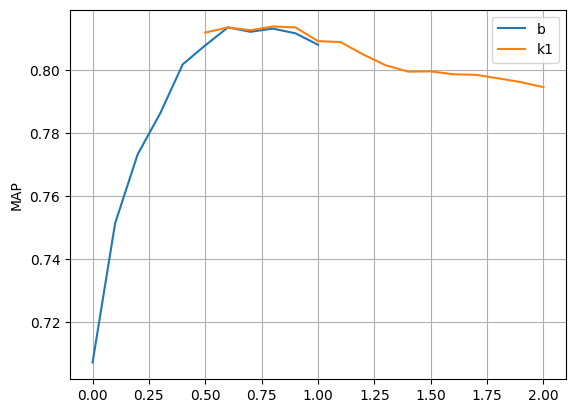

In [15]:
from matplotlib import pyplot as plt
plt.plot(plots_b["X"], plots_b["Y"], label="b")
plt.plot(plots_k1["X"], plots_k1["Y"], label="k1")
plt.ylabel("MAP")
plt.legend()
plt.grid()
plt.show()

Let's check the effectiveness gain on test after this tuning on dev

In [16]:
default_map = 0.7849
best_b = plots_b["X"][np.argmax(plots_b["Y"])]
best_k1 = plots_k1["X"][np.argmax(plots_k1["Y"])]
bm25_index = BM25Index.build_from_documents(
    documents=iter(sciq.corpus),
    ndocs=12160,
    show_progress_bar=True,
    k1=best_k1,
    b=best_b
)
bm25_index.save("output/bm25_index")
bm25_retriever = BM25Retriever(index_dir="output/bm25_index")
rankings = {}
for query in sciq.get_split_queries(Split.test):  # note this is now on test
  ranking = bm25_retriever.retrieve(query=query.text)
  rankings[query.query_id] = ranking
optimized_map = evaluate_map(rankings, split=Split.test)  # note this is now on test
print(default_map, optimized_map)

Regularizing TFs: 100%|██████████| 22683/22683 [00:00<00:00, 32793.49it/s]


0.7849 0.7990718090889324


# TASK2: CSC matrix and `CSCBM25Index` (12 points)

Recall that we use Python lists to implement posting lists, mapping term IDs to the documents in which they appear. This is inefficient due to its naive design. Actually [Compressed Sparse Column matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html) is very suitable for storing the posting lists and can boost the efficiency.

## TASK2.1: learn about `scipy.sparse.csc_matrix` (2 point)

Convert the matrix \begin{bmatrix}
0 & 1 & 0 & 3 \\
10 & 2 & 1 & 0 \\
0 & 0 & 0 & 9
\end{bmatrix} to a `csc_matrix` by specifying `data`, `indices`, `indptr` and `shape`.

In [17]:
from scipy.sparse._csc import csc_matrix

# Input matrix
input_matrix = [[0, 1, 0, 3], [10, 2, 1, 0], [0, 0, 0, 9]]

# Define data, indices, indptr, and shape
data = [10, 1, 2, 1, 3, 9]
indices = [1, 0, 1, 1, 0, 2]
indptr = [0, 1, 3, 4, 6]
shape = (3, 4)

# Create the csc_matrix
output_matrix = csc_matrix((data, indices, indptr), shape=shape)

# Print the result for verification
print(output_matrix.toarray())


[[ 0  1  0  3]
 [10  2  1  0]
 [ 0  0  0  9]]


In [18]:
## TEST_CASES (should be 3 and 11)
print((output_matrix.indices + output_matrix.data).tolist()[2])
print((output_matrix.indices + output_matrix.data).tolist()[-1])

3
11


In [19]:
## RESULT_CHECKING_POINT
print((output_matrix.indices + output_matrix.data).tolist())

[11, 1, 3, 2, 3, 11]


## TASK2.2: implement `CSCBM25Index` (4 points)

Implement `CSCBM25Index` by completing the missing code. Note that `CSCInvertedIndex` is similar to `InvertedIndex` which we talked about during the class. The main difference is posting lists are represented by a CSC sparse matrix.

In [20]:
@dataclass
class CSCInvertedIndex:
    posting_lists_matrix: csc_matrix  # docid -> posting_list
    vocab: Dict[str, int]
    cid2docid: Dict[str, int]  # collection_id -> docid
    collection_ids: List[str]  # docid -> collection_id
    doc_texts: Optional[List[str]] = None  # docid -> document text

    def save(self, output_dir: str) -> None:
        os.makedirs(output_dir, exist_ok=True)
        with open(os.path.join(output_dir, "index.pkl"), "wb") as f:
            pickle.dump(self, f)

    @classmethod
    def from_saved(cls: Type[T], saved_dir: str) -> T:
        index = cls(
            posting_lists_matrix=None, vocab={}, cid2docid={}, collection_ids=[], doc_texts=None
        )
        with open(os.path.join(saved_dir, "index.pkl"), "rb") as f:
            index = pickle.load(f)
        return index

In [21]:
@dataclass
class CSCBM25Index(CSCInvertedIndex):

    @staticmethod
    def tokenize(text: str) -> List[str]:
        return simple_tokenize(text)

    @staticmethod
    def cache_term_weights(
        posting_lists: List[PostingList],
        total_docs: int,
        avgdl: float,
        dfs: List[int],
        dls: List[int],
        k1: float,
        b: float,
    ) -> csc_matrix:
        """Compute term weights and caching"""

        ## YOUR_CODE_STARTS_HERE
        from scipy.sparse import csc_matrix
        import numpy as np

        # Prepare data for the CSC matrix
        data = []      # Term weights
        indices = []   # Row indices (document IDs)
        indptr = [0]   # Column pointers (term IDs)

        # Total number of documents
        N = total_docs

        # Efficiently compute and store term weights
        for tid, posting_list in enumerate(posting_lists):
            idf = CSCBM25Index.calc_idf(df=dfs[tid], N=N)  # Compute IDF for the term
            for docid, tf in zip(posting_list.docid_postings, posting_list.tweight_postings):
                dl = dls[docid]
                # Compute the regularized term weight and round it for compression
                term_weight = round(CSCBM25Index.calc_regularized_tf(tf, dl, avgdl, k1, b) * idf, 6)
                # Append the term weight and document ID
                data.append(term_weight)
                indices.append(docid)
            # Append the cumulative count of non-zero elements for the current term
            indptr.append(len(data))

        # Convert data to a more efficient numpy array
        data = np.array(data, dtype=np.float32)
        indices = np.array(indices, dtype=np.int32)
        indptr = np.array(indptr, dtype=np.int32)

        # Create the CSC matrix
        shape = (total_docs, len(posting_lists))  # (number of documents, number of terms)
        return csc_matrix((data, indices, indptr), shape=shape)
        ## YOUR_CODE_ENDS_HERE

    @staticmethod
    def calc_regularized_tf(
        tf: int, dl: float, avgdl: float, k1: float, b: float
    ) -> float:
        return tf / (tf + k1 * (1 - b + b * dl / avgdl))

    @staticmethod
    def calc_idf(df: int, N: int):
        return math.log(1 + (N - df + 0.5) / (df + 0.5))

    @classmethod
    def build_from_documents(
        cls: Type[CSCBM25Index],
        documents: Iterable[Document],
        store_raw: bool = True,
        output_dir: Optional[str] = None,
        ndocs: Optional[int] = None,
        show_progress_bar: bool = True,
        k1: float = 0.9,
        b: float = 0.4,
    ) -> CSCBM25Index:
        # Counting TFs, DFs, doc_lengths, etc.:
        counting = run_counting(
            documents=documents,
            tokenize_fn=CSCBM25Index.tokenize,
            store_raw=store_raw,
            ndocs=ndocs,
            show_progress_bar=show_progress_bar,
        )

        # Compute term weights and caching:
        posting_lists = counting.posting_lists
        total_docs = len(counting.cid2docid)
        posting_lists_matrix = CSCBM25Index.cache_term_weights(
            posting_lists=posting_lists,
            total_docs=total_docs,
            avgdl=counting.avgdl,
            dfs=counting.dfs,
            dls=counting.dls,
            k1=k1,
            b=b,
        )

        # Assembly and save:
        index = CSCBM25Index(
            posting_lists_matrix=posting_lists_matrix,
            vocab=counting.vocab,
            cid2docid=counting.cid2docid,
            collection_ids=counting.collection_ids,
            doc_texts=counting.doc_texts,
        )
        return index

csc_bm25_index = CSCBM25Index.build_from_documents(
    documents=iter(sciq.corpus),
    ndocs=12160,
    show_progress_bar=True,
    k1=best_k1,
    b=best_b
)
csc_bm25_index.save("output/csc_bm25_index")

Counting: 100%|██████████| 12160/12160 [00:02<00:00, 5387.82it/s]


In [22]:
## TEST_CASES (should be 7 and 95)
print(len(str(os.path.getsize("output/csc_bm25_index/index.pkl"))))
print(os.path.getsize("output/csc_bm25_index/index.pkl") // int(1e5))

7
95


In [23]:
## RESULT_CHECKING_POINT
print(os.path.getsize("output/csc_bm25_index/index.pkl"))

9522880


We can compare the size of the CSC-based index with the Python-list-based index:

In [24]:
print(os.path.getsize("output/bm25_index/index.pkl"))

15525075


## TASK2.3: implement `CSCInvertedIndexRetriever` (6 points)

Implement `CSCInvertedIndexRetriever` by completing the missing code.

In [25]:
class BaseCSCInvertedIndexRetriever(BaseRetriever):

    @property
    @abstractmethod
    def index_class(self) -> Type[CSCInvertedIndex]:
        pass

    def __init__(self, index_dir: str) -> None:
        self.index = self.index_class.from_saved(index_dir)

    def get_term_weights(self, query: str, cid: str) -> Dict[str, float]:
        ## YOUR_CODE_STARTS_HERE
        # Tokenize the query
        terms = self.index_class.tokenize(query)
        term_weights = {}

        # Get the document ID from the collection ID
        docid = self.index.cid2docid.get(cid)
        if docid is None:
            # If the collection ID is not found, return empty dict
            return term_weights

        # Iterate over each term in the query
        for term in terms:
            tid = self.index.vocab.get(term)
            if tid is not None:
                # Retrieve the BM25 weight from the CSC matrix
                bm25_weight = self.index.posting_lists_matrix[docid, tid]
                if bm25_weight > 0:
                    term_weights[term] = float(bm25_weight)

        return term_weights
        ## YOUR_CODE_ENDS_HERE

    def score(self, query: str, cid: str) -> float:
        return sum(self.get_term_weights(query=query, cid=cid).values())

    def retrieve(self, query: str, topk: int = 10) -> Dict[str, float]:
        ## YOUR_CODE_STARTS_HERE
        # Tokenize the query
        terms = self.index_class.tokenize(query)

        # Get term IDs for the query terms
        term_ids = [self.index.vocab[term] for term in terms if term in self.index.vocab]
        if not term_ids:
            # If no terms are found in the vocabulary, return empty dict
            return {}

        # Create a sparse vector for the query terms
        # Each term's weight in the query can be set to 1 (binary) or use term frequencies, etc.
        # For simplicity, we'll use binary weights
        query_vector = np.zeros(len(self.index.vocab), dtype=np.float32)
        for tid in term_ids:
            query_vector[tid] = 1.0

        # Compute BM25 scores by multiplying the CSC matrix with the query vector
        # This results in a dense array of BM25 scores for each document
        scores = self.index.posting_lists_matrix[:, term_ids].sum(axis=1).A1  # .A1 converts to 1D array

        # Identify the topk documents with the highest scores
        if topk >= len(scores):
            topk = len(scores)
        topk_docids = np.argpartition(-scores, topk)[:topk]
        topk_scores = scores[topk_docids]
        sorted_topk_indices = topk_docids[np.argsort(-topk_scores)]

        # Map document IDs back to collection IDs
        topk_collection_ids = [self.index.collection_ids[docid] for docid in sorted_topk_indices]
        topk_scores_sorted = scores[sorted_topk_indices]

        # Construct the result dictionary
        result = {
            cid: float(score) for cid, score in zip(topk_collection_ids, topk_scores_sorted)
        }

        return result
        ## YOUR_CODE_ENDS_HERE


class CSCBM25Retriever(BaseCSCInvertedIndexRetriever):

    @property
    def index_class(self) -> Type[CSCBM25Index]:
        return CSCBM25Index  # Ensure no extra characters or spaces

In [26]:
## TEST_CASES (should be close to
# {'theory': 3.1838157176971436, 'evolution': 3.488086223602295, 'natural': 2.629807710647583, 'selection': 3.552377462387085}
# {'train-11632': 16.241527557373047, 'train-10931': 13.352127075195312, 'train-2006': 12.854086875915527, 'train-7040': 12.690572738647461, 'train-1719': 11.01913833618164, 'train-9875': 10.886155128479004, 'train-1971': 10.796306610107422, 'train-9882': 10.535819053649902, 'train-2018': 10.481085777282715, 'test-586': 10.478515625}
#)
csc_bm25_retriever = CSCBM25Retriever(index_dir="output/csc_bm25_index")
query = "Who proposed the theory of evolution by natural selection?"
print(csc_bm25_retriever.get_term_weights(query=query, cid="train-2006"))
print(csc_bm25_retriever.retrieve(query))

{'theory': 3.1838159561157227, 'evolution': 3.488085985183716, 'natural': 2.629807949066162, 'selection': 3.5523769855499268}
{'train-11632': 16.241527557373047, 'train-10931': 13.352128982543945, 'train-2006': 12.854086875915527, 'train-7040': 12.690572738647461, 'train-1719': 11.01913833618164, 'train-9875': 10.886154174804688, 'train-1971': 10.796306610107422, 'train-9882': 10.535819053649902, 'train-2018': 10.481085777282715, 'test-586': 10.478516578674316}


In [27]:
## RESULT_CHECKING_POINT
csc_bm25_retriever = CSCBM25Retriever(index_dir="output/csc_bm25_index")
query = "What are the differences between immunodeficiency and autoimmune diseases?"
print(csc_bm25_retriever.get_term_weights(query=query, cid="train-1691"))
print(csc_bm25_retriever.retrieve("What are the differences between immunodeficiency and autoimmune diseases?"))

{'autoimmune': 5.041913986206055, 'diseases': 3.4281160831451416}
{'train-3853': 8.614161491394043, 'train-11549': 8.596598625183105, 'train-1691': 8.470029830932617, 'train-7688': 8.097203254699707, 'train-9715': 8.058815956115723, 'test-362': 7.84877872467041, 'test-264': 7.738605976104736, 'dev-529': 7.51554012298584, 'test-933': 6.5692033767700195, 'train-10248': 5.7757368087768555}


# TASK3: a search-engine demo based on Huggingface space (4 points)

## TASK3.1: create the gradio app (2 point)

Create a gradio app to demo the BM25 search engine index on SciQ. The app should have a single input variable for the query (of type `str`) and a single output variable for the returned ranking (of type `List[Hit]` in the code below). Please use the BM25 system with default k1 and b values.

Hint: it should use a "search" function of signature:

```python
def search(query: str) -> List[Hit]:
  ...
```

In [3]:
!pip install gradio

In [28]:
import gradio as gr
from typing import TypedDict

class Hit(TypedDict):
  cid: str
  score: float
  text: str

demo: Optional[gr.Interface] = None  # Assign your gradio demo to this variable
return_type = List[Hit]

## YOUR_CODE_STARTS_HERE
# Define the BM25 search function
def search(query: str) -> List[Hit]:
    """
    Search function for the BM25 engine.

    Args:
        query (str): The search query.

    Returns:
        List[Hit]: A list of results (documents) with their scores and texts.
    """
    retriever = CSCBM25Retriever(index_dir="output/csc_bm25_index")  # Use your index directory
    results = retriever.retrieve(query=query, topk=10)

    hits = []
    for cid, score in results.items():
        hits.append({
            "cid": cid,
            "score": score,
            "text": retriever.index.doc_texts[retriever.index.cid2docid[cid]]
        })
    return hits

# Define the Gradio app
demo = gr.Interface(
    fn=search,
    inputs=gr.Textbox(label="Enter your search query"),
    outputs=gr.Textbox(),
    title="BM25 Search Engine Demo",
    description="A demo search engine using BM25 index on the SciQ dataset."
)

## YOUR_CODE_ENDS_HERE
demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://74bd0e5697b6f971c0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [29]:
## TEST_CASES (result should be [{'cid': 'train-10966', 'score': 12.417802868109781, 'text': 'Bacteria can be used to make cheese from milk. The bacteria turn the milk sugars into lactic acid. The acid is what causes the milk to curdle to form cheese. Bacteria are also involved in producing other foods. Yogurt is made by using bacteria to ferment milk ( Figure below ). Fermenting cabbage with bacteria produces sauerkraut.'}, {'cid': 'train-0', 'score': 10.702840907292215, 'text': 'Mesophiles grow best in moderate temperature, typically between 25°C and 40°C (77°F and 104°F). Mesophiles are often found living in or on the bodies of humans or other animals. The optimal growth temperature of many pathogenic mesophiles is 37°C (98°F), the normal human body temperature. Mesophilic organisms have important uses in food preparation, including cheese, yogurt, beer and wine.'}, {'cid': 'dev-569', 'score': 9.78520518303728, 'text': 'A wide range of friendly bacteria live in the gut. Bacteria begin to populate the human digestive system right after birth. Gut bacteria include Lactobacillus , the bacteria commonly used in probiotic foods such as yogurt, and E. coli bacteria. About a third of all bacteria in the gut are members of the Bacteroides species. Bacteroides are key in helping us digest plant food.'}, {'cid': 'train-1133', 'score': 8.292180216871554, 'text': 'Osteoporosis is a disease in which bones lose mass and become more fragile than they should be. Osteoporosis also makes bones more likely to break. Two of the easiest ways to prevent osteoporosis are eating a healthy diet that has the right amount of calcium and vitamin D and to do some sort of weight-bearing exercise every day. Foods that are a good source of calcium include milk, yogurt, and cheese. Non-dairy sources of calcium include Chinese cabbage, kale, and broccoli. Many fruit juices, fruit drinks, tofu, and cereals have calcium added to them. It is recommended that teenagers get 1300 mg of calcium every day. For example, one cup (8 fl. oz. ) of milk provides about 300 mg of calcium, or about 30% of the daily requirement.'}, {'cid': 'train-5314', 'score': 8.211635318028303, 'text': 'Bacteria are often used to make cheese from milk. But making foods is not the only beneficial role of bacteria. For example, they also play an essential role in your gut!.'}, {'cid': 'train-6684', 'score': 8.168255107424818, 'text': 'Osteoporosis is a disease in which bones lose mass and become more fragile than they should be. Osteoporosis also makes bones more likely to break. Two of the easiest ways to prevent osteoporosis are eating a healthy diet that has the right amount of calcium and vitamin D and to do some sort of weight-bearing exercise every day. Foods that are a good source of calcium include milk, yogurt, and cheese. Non-dairy sources of calcium include Chinese cabbage, kale, and broccoli. Many fruit juices, fruit drinks, tofu, and cereals have calcium added to them. It is recommended that teenagers get 1300 mg of calcium every day. For example, one cup (8 fl. oz. ) of milk provides about 300 mg of calcium, or about 30% of the daily requirement. Other sources of calcium are pictured in the Figure below .'}, {'cid': 'train-7890', 'score': 7.930578384187305, 'text': 'Animals and some bacteria and fungi carry out lactic acid fermentation. Lactic acid is a waste product of this process. Our muscles perform lactic acid fermentation during strenuous exercise, since oxygen cannot be delivered to the muscles quickly enough. The buildup of lactic acid is believed to make your muscles sore after exercise. Bacteria that produce lactic acid are used to make cheese and yogurt. The lactic acid causes the proteins in milk to thicken. Lactic acid also causes tooth decay, because bacteria use the sugars in your mouth for energy.'}, {'cid': 'train-6916', 'score': 7.833677059320589, 'text': 'Yogurt is a good source of calcium. Yogurt also contains active cultures of "good" bacteria. Foods that contain these beneficial bacteria are sometimes called "probiotic. ".'}, {'cid': 'train-10029', 'score': 7.725028405457634, 'text': 'Humans have collected and grown mushrooms for food for thousands of years. Figure below shows some of the many types of mushrooms that people eat. Yeasts are used in bread baking and brewing alcoholic beverages. Other fungi are used in fermenting a wide variety of foods, including soy sauce, tempeh, and cheeses. Blue cheese has its distinctive appearance and flavor because of the fungus growing though it (see Figure below ).'}, {'cid': 'train-10983', 'score': 7.334055808872751, 'text': "No doubt you've had a sore throat before, and you've probably eaten cheese or yogurt. If so, then you've already encountered the amazing world of prokaryotes. Prokaryotes are single-celled organisms that lack a nucleus. They also lack other membrane-bound organelles. Prokaryotes are tiny. They can only be viewed with a microscope (see Figure below ). But they are the most numerous organisms on Earth. Without them, the world would be a very different place."}])
import requests
import json

headers = {"Content-Type": "application/json"}
data = {"data": ["What type of organism is commonly used in preparation of foods such as cheese and yogurt?"]}
response = requests.post(f"{demo.local_api_url.strip('/')}/call/predict", headers=headers, data=json.dumps(data))
event_id = response.json()["event_id"]
response = requests.get(f"{demo.local_api_url.strip('/')}/call/predict/{event_id}", stream=True)
lines = list(response.iter_lines())
print(eval(json.loads(lines[1].decode("UTF-8").replace("data:", ""))[0]))

[{'cid': 'train-10966', 'score': 13.210095405578613, 'text': 'Bacteria can be used to make cheese from milk. The bacteria turn the milk sugars into lactic acid. The acid is what causes the milk to curdle to form cheese. Bacteria are also involved in producing other foods. Yogurt is made by using bacteria to ferment milk ( Figure below ). Fermenting cabbage with bacteria produces sauerkraut.'}, {'cid': 'train-0', 'score': 11.36720085144043, 'text': 'Mesophiles grow best in moderate temperature, typically between 25°C and 40°C (77°F and 104°F). Mesophiles are often found living in or on the bodies of humans or other animals. The optimal growth temperature of many pathogenic mesophiles is 37°C (98°F), the normal human body temperature. Mesophilic organisms have important uses in food preparation, including cheese, yogurt, beer and wine.'}, {'cid': 'dev-569', 'score': 10.411890029907227, 'text': 'A wide range of friendly bacteria live in the gut. Bacteria begin to populate the human digest

In [30]:
## RESULT_CHECKING_POINT
import requests
import json

headers = {"Content-Type": "application/json"}
data = {"data": ["What are the differences between immunodeficiency and autoimmune diseases?"]}
response = requests.post(f"{demo.local_api_url.strip('/')}/call/predict", headers=headers, data=json.dumps(data))
event_id = response.json()["event_id"]
response = requests.get(f"{demo.local_api_url.strip('/')}/call/predict/{event_id}", stream=True)
lines = list(response.iter_lines())
print(eval(json.loads(lines[1].decode("UTF-8").replace("data:", ""))[0]))

[{'cid': 'train-3853', 'score': 8.614161491394043, 'text': 'Autoimmune diseases occur when the immune system fails to recognize the body’s own molecules as “self,” or belonging to the person. Instead, it attacks body cells as though they were dangerous pathogens. There are more than 80 known autoimmune diseases. Recall that regulatory T cells help regulate the immune system. When autoimmune disorders occur, these regulatory T cells fail in their function. This results in damage to various organs and tissues. The type of autoimmune disorder depends on the type of body tissue that is affected.'}, {'cid': 'train-11549', 'score': 8.596598625183105, 'text': 'Immunologist The variations in peripheral proteins and carbohydrates that affect a cell’s recognition sites are of prime interest in immunology. These changes are taken into consideration in vaccine development. Many infectious diseases, such as smallpox, polio, diphtheria, and tetanus, were conquered by the use of vaccines. Immunologis

## TASK3.2: upload it to Huggingface Space (2 point)

Upload your gradio app to Huggingface Space. Put your URL to the Space app in the variable `hf_space_url`.

IMPORTANT!!! You can get this URL from:

*Your Space page* -> *"three dots" on the top right* -> "embedd this space" -> "Direct URL"

An example URL (not for our task) is: https://stabilityai-stable-diffusion-3-5-large.hf.space (from https://huggingface.co/spaces/stabilityai/stable-diffusion-3.5-large)

In [ ]:
hf_space_url: Optional[str] = None  # Store your created Huggingface Space URL in this variable
## YOUR_CODE_STARTS_HERE
## YOUR_CODE_ENDS_HERE

## RESULT_CHECKING_POINT
import requests
import json

print(hf_space_url)
headers = {"Content-Type": "application/json"}
data = {"data": ["What are the differences between immunodeficiency and autoimmune diseases?"]}
response = requests.post(f"{hf_space_url.strip('/')}/call/predict", headers=headers, data=json.dumps(data))
event_id = response.json()["event_id"]
response = requests.get(f"{hf_space_url.strip('/')}/call/predict/{event_id}", stream=True)
lines = list(response.iter_lines())
print(eval(json.loads(lines[1].decode("UTF-8").replace("data:", ""))[0]))

In [ ]:
## TEST_CASES  (result should be [{'cid': 'train-5587', 'score': 26.74537329473182, 'text': 'The entropy change is positive as the solid state changes into the liquid state. If the transition went from the liquid to the solid state, the numerical value for would be the same, but the sign would be reversed since we are going from a less ordered to a more ordered situation.'}, {'cid': 'train-2', 'score': 25.93532475963942, 'text': 'Summary Changes of state are examples of phase changes, or phase transitions. All phase changes are accompanied by changes in the energy of a system. Changes from a more-ordered state to a less-ordered state (such as a liquid to a gas) areendothermic. Changes from a less-ordered state to a more-ordered state (such as a liquid to a solid) are always exothermic. The conversion of a solid to a liquid is called fusion (or melting). The energy required to melt 1 mol of a substance is its enthalpy of fusion (ΔHfus). The energy change required to vaporize 1 mol of a substance is the enthalpy of vaporization (ΔHvap). The direct conversion of a solid to a gas is sublimation. The amount of energy needed to sublime 1 mol of a substance is its enthalpy of sublimation (ΔHsub) and is the sum of the enthalpies of fusion and vaporization. Plots of the temperature of a substance versus heat added or versus heating time at a constant rate of heating are calledheating curves. Heating curves relate temperature changes to phase transitions. A superheated liquid, a liquid at a temperature and pressure at which it should be a gas, is not stable. A cooling curve is not exactly the reverse of the heating curve because many liquids do not freeze at the expected temperature. Instead, they form a supercooled liquid, a metastable liquid phase that exists below the normal melting point. Supercooled liquids usually crystallize on standing, or adding a seed crystal of the same or another substance can induce crystallization.'}, {'cid': 'train-1658', 'score': 19.0263955721366, 'text': 'There are many examples in the chemical world of changes in entropy. Phase transitions are one obvious example. When a substance makes a transition from the liquid state to the gaseous state, the particles have many more possible arrangements, because they are no longer confined to a specified volume in which they are close to each other; gas particles can move freely throughout their container. Vaporization represents an increase in entropy. In the opposite direction, a liquid loses entropy when it freezes to a solid. Because solids have very ordered structures, there are fewer possible arrangements of particles that would result in the properties associated with a solid.'}, {'cid': 'train-5603', 'score': 16.14918704233498, 'text': 'Chemical energy, the energy stored in molecules and atoms, is one type of potential energy. Certain reactions can cause this energy to be released as heat. Other reactions require an input of energy, in which case the products will store more potential energy than the reactants. When we studied phase changes, we saw a relationship between energy and the state of matter. To melt a solid or boil a liquid, energy needs to be added in order to break up the intermolecular forces holding particles together in more ordered states. The reverse processes, condensation and freezing, release energy, because more favorable intermolecular interactions are formed.'}, {'cid': 'train-8144', 'score': 13.369317026860408, 'text': 'Solid carbon dioxide is also called dry ice. That’s because when it gets warmer and changes state, it doesn’t change to a liquid by melting. Instead, it changes directly to a gas without going through the liquid state. The process in which a solid changes directly to a gas is called sublimation . It occurs when energy is added to a solid such as dry ice. You can watch dry ice changing directly to a gas in the video at this URL: http://www. youtube. com/watch?v=J8mDGwf-5x0 .'}, {'cid': 'train-844', 'score': 12.931270408607555, 'text': 'The water droplets of fog form from water vapor in the air. Fog disappears when the water droplets change back to water vapor. These changes are examples of changes of state. A change of state occurs whenever matter changes from one state to another. Common states of matter on Earth are solid, liquid, and gas. Matter may change back and forth between any two of these states.'}, {'cid': 'train-9811', 'score': 12.904636038613848, 'text': 'Start right above point on the temperature axis and follow the red line vertically. At very low pressure, the particles of the substance are far apart from one another and the substance is in the gas state. As the pressure is increased, the particles of the substance are forced closer and closer together. Eventually the particles are pushed so close together that attractive forces cause the substance to condense into the liquid state. Continually increasing the pressure on the liquid will eventually cause the substance to solidify. For the majority of substances, the solid state is denser than the liquid state and so putting a liquid under great pressure will cause it to turn into a solid. The line segment represents the process of sublimation, where the substance changes directly from a solid to a gas. At a sufficiently low pressure, the liquid phase does not exist. The point labeled is called the triple point . The triple point is the one condition of temperature and pressure where the solid, liquid, and vapor states of a substance can all coexist at equilibrium.'}, {'cid': 'train-8260', 'score': 12.876342252900347, 'text': 'Unlike a crystalline solid, an amorphous solid is a solid that lacks an ordered internal structure. Some examples of amorphous solids include rubber, plastic, and gels. Glass is a very important amorphous solid that is made by cooling a mixture of materials in such a way that it does not crystallize. Glass is sometimes referred to as a supercooled liquid rather than a solid. If you have ever watched a glassblower in action, you have noticed that he takes advantage of the fact that amorphous solids do not have a distinct melting point like crystalline solids do. Instead, as glass is heated, it slowly softens and can be shaped into all sorts of interesting forms. When a glass object shatters, it does so in a very irregular way, unlike crystalline solids, which always break into fragments that have the same shape as dictated by its crystal system.'}, {'cid': 'train-317', 'score': 12.82403749702155, 'text': 'An amorphous solid is a solid that lacks an ordered internal structure.'}, {'cid': 'train-6203', 'score': 12.76684203292532, 'text': 'Matter can exist in one of several different states, including a gas, liquid, or solid state. States of matter differ in the amount of energy their molecules have. When matter recycles, it changes state by gaining or losing energy.'}]
import requests
import json

headers = {"Content-Type": "application/json"}
data = {"data": ["Changes from a less-ordered state to a more-ordered state (such as a liquid to a solid) are always what?"]}
response = requests.post(f"{hf_space_url.strip('/')}/call/predict", headers=headers, data=json.dumps(data))
event_id = response.json()["event_id"]
response = requests.get(f"{hf_space_url.strip('/')}/call/predict/{event_id}", stream=True)
lines = list(response.iter_lines())
print(eval(json.loads(lines[1].decode("UTF-8").replace("data:", ""))[0]))